In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
%load_ext autoreload
%autoreload 2
from sklearn.preprocessing import PolynomialFeatures

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [37]:
polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(tX)
print(x_poly)

[[  1.00000000e+00   1.38470000e+02   5.16550000e+01 ...,   6.12562500e+00
   -2.80905075e+02   1.28815690e+04]
 [  1.00000000e+00   1.60937000e+02   6.87680000e+01 ...,   9.98001000e+05
   -4.61797740e+04   2.13684308e+03]
 [  1.00000000e+00  -9.99000000e+02   1.62172000e+02 ...,   9.98001000e+05
   -4.42067490e+04   1.95815100e+03]
 ..., 
 [  1.00000000e+00   1.05457000e+02   6.05260000e+01 ...,   9.98001000e+05
   -4.19500080e+04   1.76332806e+03]
 [  1.00000000e+00   9.49510000e+01   1.93620000e+01 ...,   9.98001000e+05
   -0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00  -9.99000000e+02   7.27560000e+01 ...,   9.98001000e+05
   -0.00000000e+00   0.00000000e+00]]


In [39]:
for i in range(496):
    print(x_poly[0][i])

1.0
138.47
51.655
97.827
27.98
0.91
124.711
2.666
3.064
41.928
197.76
1.582
1.396
0.2
32.638
1.017
0.381
51.626
2.273
-2.414
16.824
-0.277
258.733
2.0
67.435
2.15
0.444
46.062
1.24
-2.475
113.497
19173.9409
7152.66785
13546.10469
3874.3906
126.0077
17268.73217
369.16102
424.27208
5805.77016
27383.8272
219.05954
193.30412
27.694
4519.38386
140.82399
52.75707
7148.65222
314.74231
-334.26658
2329.61928
-38.35619
35826.75851
276.94
9337.72445
297.7105
61.48068
6378.20514
171.7028
-342.71325
15715.92959
2668.239025
5053.253685
1445.3069
47.00605
6441.946705
137.71223
158.27092
2165.79084
10215.2928
81.71821
72.11038
10.331
1685.91589
52.533135
19.680555
2666.74103
117.411815
-124.69517
869.04372
-14.308435
13364.853115
103.31
3483.354925
111.05825
22.93482
2379.33261
64.0522
-127.846125
5862.687535
9570.121929
2737.19946
89.02257
12200.102997
260.806782
299.741928
4101.690456
19346.26752
154.762314
136.566492
19.5654
3192.877626
99.490059
37.272087
5050.416702
222.360771
-236.154378
1645.84

### Features cleaning

In [3]:
def print_percentages(array):
    for j in range(array.shape[1]):
        count_col = 0
        for i in range(array.shape[0]):
            if array[i,j] == -999:
                count_col += 1
        count_col = (count_col/array.shape[0])*100
        print(f'For the feature {j+1} : {count_col} % of missing values')

In [4]:
# standardize the matrix (not affected by undetermined values)
def standardize(tX, affected = False) :
    tX_standardized = tX.copy()
    for feature in tX_standardized.T : 
        mask = (feature != -999)
        i_mask = (feature == -999)
        if affected :
            feature[i_mask] = feature[mask].mean() # replace undetermined value by 0
            feature[:] = (feature-feature.mean())/feature.std() # standardize
        else :
            feature[i_mask] = 0 # replace undetermined value by mean of column
            feature[mask] = (feature[mask]-feature[mask].mean())/feature[mask].std() # standardize
    tX_standardized.T[22] = tX.T[22]
    tX_standardized = np.c_[tX_standardized, np.ones((tX.shape[0], 1))]
    return tX_standardized

In [5]:
# standardize the matrix (affected by undetermined values)
tX_standardized = standardize(tX)
tX_standardized_af = standardize(tX, affected = True)

In [58]:
# Create mask removing columns with unvalid data
remove_na_mask = []
for j in range(tX.shape[1]):
    remove_na_mask.append(not (-999 in tX[:,j]))
remove_na_mask.append(True) # for 1 column

In [59]:
# Create mask removing columns with unvalid data except the first one because it has only 15% on error
remove_error_mask = []
for j in range(tX.shape[1]):
    remove_error_mask.append(not (-999 in tX[:,j]))
remove_error_mask[0] = True
remove_error_mask.append(True) # for 1 column

In [60]:
# Create mask removing all columns with unvalid or 0 data
remove_all_mask = []
for j in range(tX.shape[1]):
    remove_all_mask.append(not (-999 in tX[:,j]))
remove_all_mask[29] = False
remove_all_mask[22] = False
remove_all_mask.append(True)

In [76]:
print(remove_all_mask)

[False, True, True, True, False, False, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, True]


In [21]:
# Create manual mask based on observations
manual_mask = np.full(tX_standardized.shape[1] ,False)
# 0, 1, 2, 3, 7, 9, 16, 19, 21, 29
#manual_mask[[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]] = True
manual_mask[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]] = True

In [97]:
print(manual_mask)

[False  True  True  True  True  True  True  True  True  True  True False
 False False False False False False False False False False False False
 False False False False False False False]


In [98]:
clean_cols = tX_standardized[:, remove_error_mask]

Feature  1


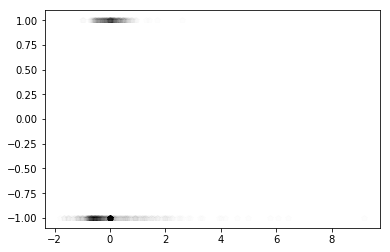

Feature  2


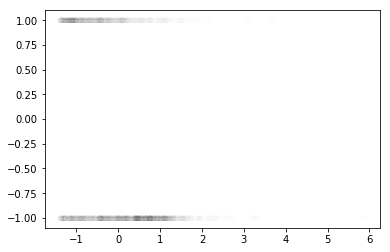

Feature  3


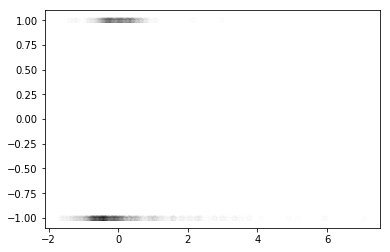

Feature  4


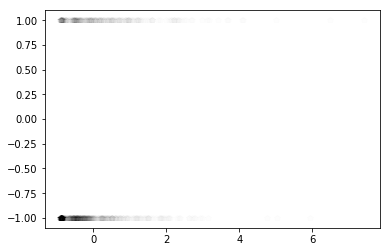

Feature  5


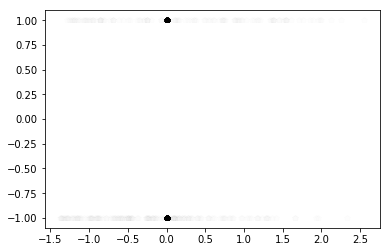

Feature  6


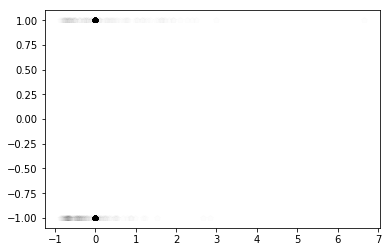

Feature  7


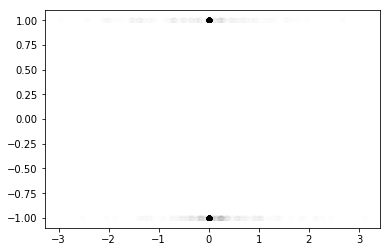

Feature  8


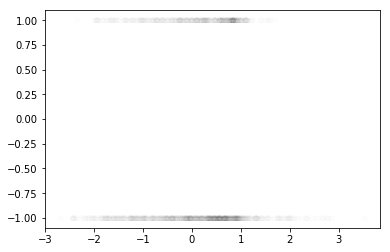

Feature  9


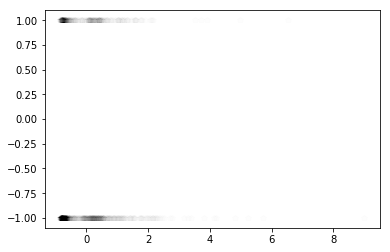

Feature  10


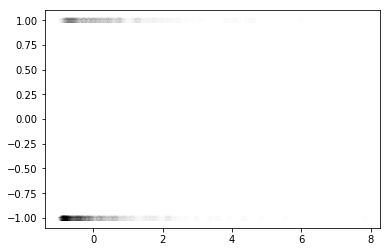

Feature  11


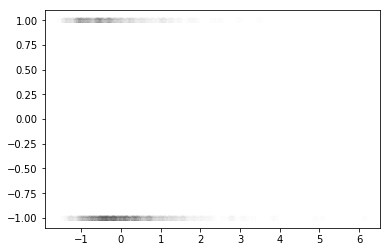

Feature  12


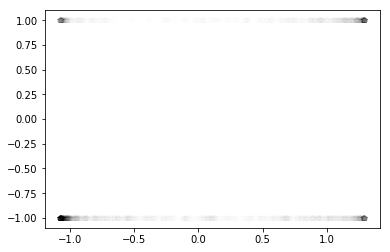

Feature  13


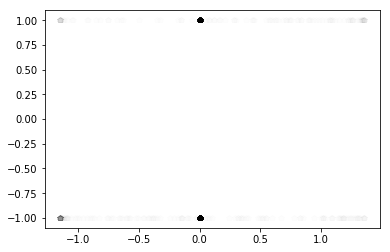

Feature  14


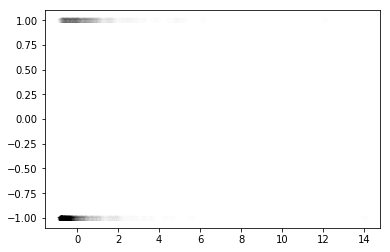

Feature  15


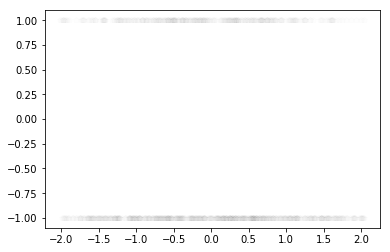

Feature  16


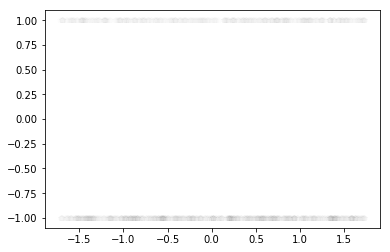

Feature  17


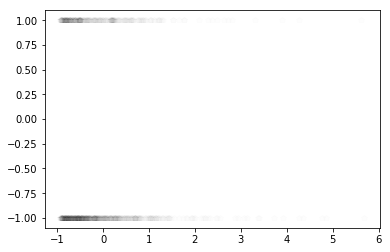

Feature  18


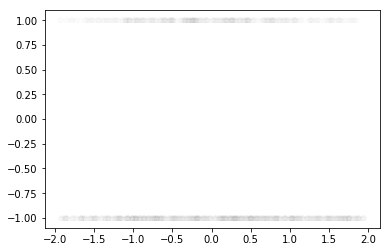

Feature  19


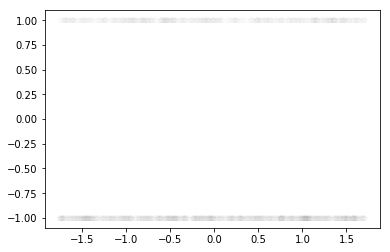

Feature  20


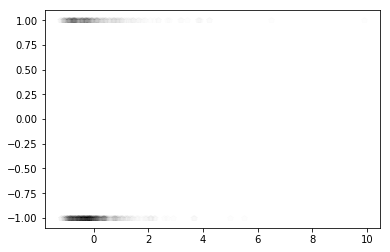

Feature  21


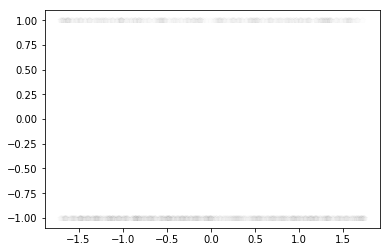

Feature  22


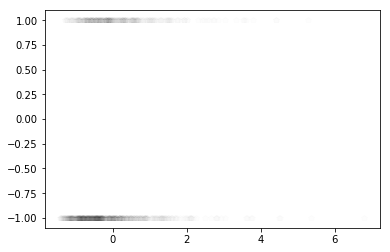

Feature  23


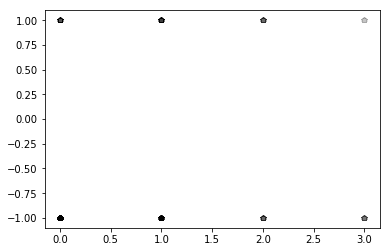

Feature  24


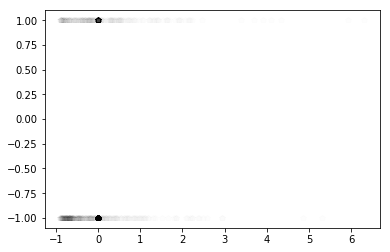

Feature  25


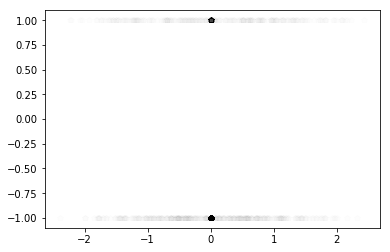

Feature  26


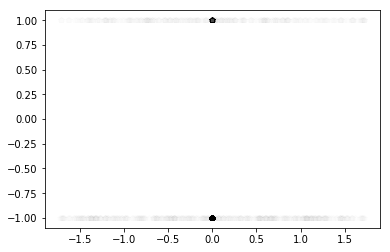

Feature  27


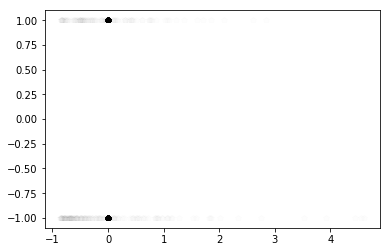

Feature  28


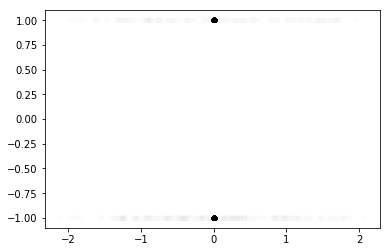

Feature  29


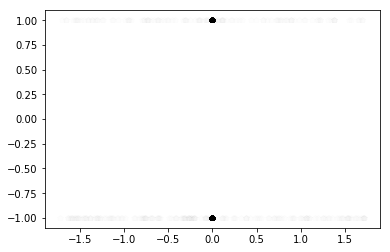

Feature  30


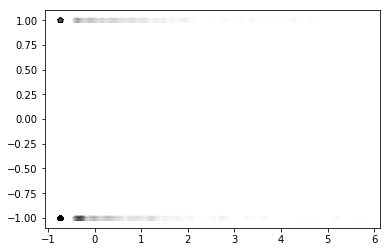

Feature  31


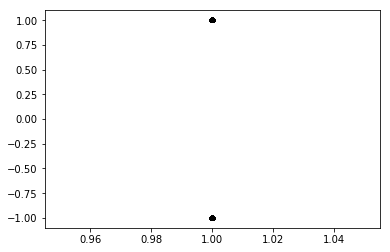

In [26]:
 for i, feature in enumerate(tX_standardized.T) :
    print("Feature " , i+1)
    plt.plot(feature[:1000], y[:1000], 'kp', alpha = 0.006)
    plt.show()

### Useful functions

In [7]:
def accuracy(weights, x_test, y_test):
    y_pred = predict_labels(weights, x_test)
    return np.count_nonzero(y_test == y_pred) / (y_pred.shape[0])

### Least squares with columns removed except the first one

In [29]:
tX_temp = tX_standardized[:, remove_error_mask]
initial_w = np.zeros(tX_temp.shape[1])
lambda_ = 50
weights, loss = least_squares(y, tX_temp)
print(weights)
# 0.729

[  8.84154244e-03  -2.60893476e-01  -2.67081991e-01   3.83524961e-03
   2.83950915e-01  -4.06555948e-02  -3.60360264e+02  -1.93720747e-01
   1.31844365e-01   6.99938249e+01  -8.99902378e-04  -8.58011200e-04
   6.90151485e+01  -6.11791100e-04   2.32554240e-03   1.06072219e-01
   8.30085699e-04  -7.01606787e-02   8.55952762e-02   3.05208207e+02
  -3.98476840e-01]


In [28]:
w_0 = np.zeros(tX_standardized.shape()[1])
w_0[remove_error_mask] = weights
weights = w_0

TypeError: 'tuple' object is not callable

### Least square with build polynomial expansion  and without column remove

In [8]:
tX_temp = tX_standardized_af[:, manual_mask]
initial_w = np.zeros(tX_temp.shape[1])
x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.7, seed = 1)
degrees = [1, 2, 3, 4, 5]
# tuning which degree makes the best prediction on the validation set.
rmse_tr = []
rmse_te = []
acc = {}

for ind, degree in enumerate(degrees):
    polynomial_features = PolynomialFeatures(degree)
    #train_poly_x = build_poly(x_train, degree)
    #test_poly_x = build_poly(x_test, degree)
    train_poly_x = polynomial_features.fit_transform(x_train)
    test_poly_x = polynomial_features.fit_transform(x_test)
    
    w, mse_loss_train = least_squares(y_train, train_poly_x)
    
    rmse_tr.append(compute_rmse(y_train, train_poly_x, w))
    rmse_te.append(compute_rmse(y_test, test_poly_x, w))
    acc[degree] = accuracy(w, test_poly_x, y_test)
plot_train_test(rmse_tr, rmse_te, degrees)

KeyboardInterrupt: 

In [ ]:
print(acc)

### Least square with the first 10 column and feature expansion

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=10.0, right=10.0
  'left=%s, right=%s') % (left, right))


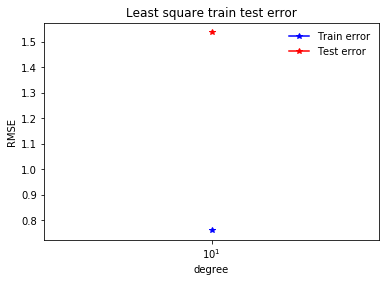

In [32]:
tX_temp = tX_standardized_af[:, manual_mask]
initial_w = np.zeros(tX_temp.shape[1])
x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.7, seed = 1)
degrees = [10]
# tuning which degree makes the best prediction on the validation set.
rmse_tr = []
rmse_te = []

rmse_min = np.inf
degree_opt = 0
# disctionnary degree -> accuracy of the model on the test set given the degree
acc = {}
title = 'Least square train test error'
for ind, degree in enumerate(degrees):
    polynomial_features = PolynomialFeatures(degree)
    #train_poly_x = build_poly(x_train, degree)
    #test_poly_x = build_poly(x_test, degree)
    # polynomial expension
    train_poly_x = build_multi_poly(x_train, degree)
    test_poly_x = build_multi_poly(x_test, degree)
    
    w, mse_loss_train = least_squares(y_train, train_poly_x)
    
    # keep track of the loss for ploting
    rmse_tr.append(compute_rmse(y_train, train_poly_x, w))
    rmse_test = compute_rmse(y_test, test_poly_x, w)
    rmse_te.append(rmse_test)
    acc[degree] = accuracy(w, test_poly_x, y_test)
    #if rmse_test < rmse_min:
    #    rmse_min = rmse_test
    #    weights = w
    #    degree_opt = degree
    weights = w
    
plot_train_test(rmse_tr, rmse_te, degrees, title)

In [31]:
acc

{10: 0.8036933333333334}

In [129]:
print(weights.shape)

(3003,)


### Ridge regression with the first 10 columns and feature expension

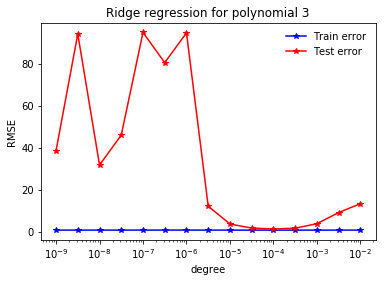

In [40]:
tX_temp = tX_standardized_af[:, manual_mask]
initial_w = np.zeros(tX_temp.shape[1])
x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.7, seed = 1)
degree = 12
# tuning which degree makes the best prediction on the validation set.
rmse_tr = []
rmse_te = []
# disctionnary degree -> accuracy of the model on the test set given the lambda
acc = {}

rmse_min = np.inf
lambda_opt = 0

title = 'Ridge regression for polynomial 3'
# define parameter
lambdas = np.logspace(-9, -2, 15)

polynomial_features = PolynomialFeatures(degree)
# polynomial expension
train_poly_x = build_multi_poly(x_train, degree)
test_poly_x = build_multi_poly(x_test, degree)

for ind, lambda_ in enumerate(lambdas):
    
    w, loss = ridge_regression(y_train, train_poly_x, lambda_)
    
    # keep track of the loss for ploting
    rmse_tr.append(compute_rmse(y_train, train_poly_x, w))
    rmse_te.append(compute_rmse(y_test, test_poly_x, w))
    acc[lambda_] = accuracy(w, test_poly_x, y_test)
    if rmse_test < rmse_min:
        rmse_min = rmse_test
        weights = w
        lambda_opt = lambda_
    
plot_train_test(rmse_tr, rmse_te, lambdas, title)

In [41]:
acc

{1.0000000000000001e-09: 0.8066533333333333,
 3.1622776601683795e-09: 0.8037066666666667,
 1e-08: 0.8061733333333333,
 3.1622776601683792e-08: 0.8033066666666666,
 9.9999999999999995e-08: 0.8008133333333334,
 3.1622776601683792e-07: 0.80128,
 9.9999999999999995e-07: 0.7949466666666667,
 3.1622776601683792e-06: 0.8064133333333333,
 1.0000000000000001e-05: 0.8067466666666666,
 3.1622776601683795e-05: 0.80688,
 0.0001: 0.8070266666666667,
 0.00031622776601683794: 0.8070266666666667,
 0.001: 0.8069466666666667,
 0.0031622776601683794: 0.8065066666666667,
 0.01: 0.80428}

### Logistic regression with the first 10 columns and extended features

In [ ]:
tX_temp = tX_standardized_af[:, manual_mask]
initial_w = np.zeros(tX_temp.shape[1])
x_train, x_test, y_train, y_test = split_data(tX_temp, y, 0.7, seed = 1)
degree = 3
# tuning which degree makes the best prediction on the validation set.
rmse_tr = []
rmse_te = []
# disctionnary degree -> accuracy of the model on the test set given the lambda
acc = {}

rmse_min = np.inf
lambda_opt = 0

title = 'Ridge regression for polynomial 3'
# define parameter
lambdas = np.logspace(-9, -2, 15)

polynomial_features = PolynomialFeatures(degree)
# polynomial expension
train_poly_x = polynomial_features.fit_transform(x_train)
test_poly_x = polynomial_features.fit_transform(x_test)


train_poly_x = polynomial_features.fit_transform(x_train)
test_poly_x = polynomial_features.fit_transform(x_test)
weights, loss = logistic_regression(y, tX_temp, initial_w, 1000, 0.0000001)

# keep track of the loss for ploting
rmse_tr.append(compute_rmse(y_train, train_poly_x, w))
rmse_te.append(compute_rmse(y_test, test_poly_x, w))
acc[lambda_] = accuracy(w, test_poly_x, y_test)
if rmse_test < rmse_min:
    rmse_min = rmse_test
    weights = w
    lambda_opt = lambda_
    
plot_train_test(rmse_tr, rmse_te, lambdas, title)

### Logistic regression with columns removed

In [62]:
# polynomial expension
train_poly_x = build_multi_poly(tX_standardized_af[:, manual_mask], 7)
initial_w = np.zeros(train_poly_x.shape[1])
x_train, x_test, y_train, y_test = split_data(train_poly_x, y, 0.7, seed = 1)


weights, loss = logistic_regression(y_train, x_train, initial_w, 1000, 0.001)



/Users/stanislasjouven/Documents/EPFL/master1/ml/ml_group_work/ML_course/projects/project1/scripts/implementations.py:75: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1 + np.exp(tx @ w)) - y * (tx @ w))
/Users/stanislasjouven/Documents/EPFL/master1/ml/ml_group_work/ML_course/projects/project1/scripts/implementations.py:69: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-t)),
/Users/stanislasjouven/Documents/EPFL/master1/ml/ml_group_work/ML_course/projects/project1/scripts/implementations.py:70: RuntimeWarning: overflow encountered in exp
  np.exp(t) / (1 + np.exp(t)))
/Users/stanislasjouven/Documents/EPFL/master1/ml/ml_group_work/ML_course/projects/project1/scripts/implementations.py:70: RuntimeWarning: invalid value encountered in true_divide
  np.exp(t) / (1 + np.exp(t)))


In [63]:
y_pred = predict_labels(weights, x_test)
np.count_nonzero(y_test == y_pred) / (y_pred.shape[0])

0.5624533333333334

In [578]:
print(weights)

[ 2.58267765e-02 -6.85267338e-01 -1.01495128e+00  2.91998731e-01
 -3.11589633e-02  4.01266731e-01  4.16661756e-02  1.04064752e+00
 -9.14797437e-02  2.87061987e-01 -7.06948381e-01  2.50714125e-01
  2.19328298e-01  4.73925028e-01 -2.29059335e-03 -2.30463305e-03
  8.97754906e-01 -3.03452442e-03  6.84233625e-03  1.54091825e-01
  3.05476951e-04 -1.39990610e-01 -8.01590665e-02 -2.74284284e-01
  8.80844950e-04 -6.01861681e-04 -2.17767265e-01  5.67343756e-03
 -4.39140173e-03  2.84071572e-02 -8.05158341e-01]


In [567]:
w_0 = np.zeros(tX_temp.shape[1])
w_0[mask] = weights
weights = w_0

ValueError: NumPy boolean array indexing assignment cannot assign 31 input values to the 2 output values where the mask is true

## Generate predictions and save ouput in csv format for submission:

In [42]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [43]:
#standardize tX_test
tX_test_standardized = standardize(tX_test)
tX_test_standardized_af = standardize(tX_test, affected = True)

In [44]:
# extended feature here degree 4
tX_test = build_multi_poly(tX_test_standardized_af[:, manual_mask], 12)

In [45]:
OUTPUT_PATH = '../data/submission_file.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)